# Benchmark all integration methods

In this notebook the different integration methods of outputs produced by rest of the notebooks in this folder are benchmarked with scib-metrics
For now I have cloned the repo into my working directory as there is one bug which I reported here: https://github.com/YosefLab/scib-metrics/pull/106
When directly using it via PIP I recieve an error, so for now clone the repo from branch `robinmittas:patch-1`

**Requires:**
- `/vol/storage/data/pancreas_sc_multiome/sn_sc_rna_scglue_e15.5.h5ad`
- `/vol/storage/data/pancreas_sc_multiome/atac_sc_rna_scglue_e15.5.h5ad`
- `/vol/storage/data/pancreas_sc_multiome/sn_sc_rna_scvi_e15.5.h5ad`
- `/vol/storage/data/pancreas_sc/processed/gex_e15.5.h5ad`
- `/vol/storage/data/pancreas_multiome/processed/gex_e15.5.h5ad`

## Library imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import time

import mplscience
from plottable import ColumnDefinition, Table
from plottable.cmap import normed_cmap
from plottable.plots import bar
from scib_metrics.benchmark import Benchmarker, BioConservation

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import anndata as ad
import scanpy as sc

sys.path.append("../..")
from paths import FIG_DIR, PROJECT_DIR  # isort: skip  # noqa: E402

## General settings

In [3]:
SAVE_FIGURES = True

SN_PROCESSED_DIR = PROJECT_DIR / "pancreas_multiome" / "processed"
SC_PROCESSED_DIR = PROJECT_DIR / "pancreas_sc" / "processed"
SN_SC_PROCESSED_DIR = PROJECT_DIR / "pancreas_sc_multiome"

_METRIC_TYPE = "Metric Type"
_AGGREGATE_SCORE = "Aggregate score"

# Mapping of metric fn names to clean DataFrame column names
metric_name_cleaner = {
    "silhouette_label": "Silhouette label",
    "silhouette_batch": "Silhouette batch",
    "isolated_labels": "Isolated labels",
    "nmi_ari_cluster_labels_leiden_nmi": "Leiden NMI",
    "nmi_ari_cluster_labels_leiden_ari": "Leiden ARI",
    "nmi_ari_cluster_labels_kmeans_nmi": "KMeans NMI",
    "nmi_ari_cluster_labels_kmeans_ari": "KMeans ARI",
    "clisi_knn": "cLISI",
    "ilisi_knn": "iLISI",
    "kbet_per_label": "KBET",
    "graph_connectivity": "Graph connectivity",
    "pcr_comparison": "PCR comparison",
}

## Function defintions

In [4]:
def plot_subpart_scib(plot_df, score_cols, column_definitions, save_file_name):
    """Plots give columns of scIB metric as table.

    Parameters
    ----------
    plot_df
        Pandas df containing scIB metrics per embedding
    score_cols
        Columns to Plot
    column_definitions
        Of type `from plottable import ColumnDefinition`
    save_file_name
        Filename to store plot
    """
    with matplotlib.rc_context({"svg.fonttype": "none"}):
        fig, ax = plt.subplots(figsize=(8, 3))
        Table(
            plot_df[list(score_cols) + ["Method"]],
            cell_kw={
                "linewidth": 0,
                "edgecolor": "k",
            },
            column_definitions=column_definitions,
            ax=ax,
            row_dividers=True,
            footer_divider=True,
            textprops={"fontsize": 10, "ha": "center"},
            row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
            col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
            column_border_kw={"linewidth": 1, "linestyle": "-"},
            index_col="Method",
        )
        plt.show()
        if SAVE_FIGURES:
            fig.savefig(FIG_DIR / save_file_name, facecolor=ax.get_facecolor(), dpi=300)

## Read Data

In [5]:
adata_sn = sc.read(SN_PROCESSED_DIR / "gex_e15.5.h5ad")
adata_sc = sc.read(SC_PROCESSED_DIR / "gex_e15.5.h5ad")

atac_sc_glue = sc.read(SN_SC_PROCESSED_DIR / "atac_sc_rna_scglue_e15.5.h5ad")
sn_sc_glue = sc.read(SN_SC_PROCESSED_DIR / "sn_sc_rna_scglue_e15.5.h5ad")
sn_sc_scvi = sc.read(SN_SC_PROCESSED_DIR / "sn_sc_rna_scvi_e15.5.h5ad")

## Preprocess scRNA-seq data

In [6]:
adata = ad.concat([adata_sc, adata_sn])
adata

/vol/storage/miniconda3/envs/conda_env_robin/lib/python3.9/site-packages/anndata/_core/merge.py:217: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(dtype):


AnnData object with n_obs × n_vars = 8412 × 13255
    obs: 'day', 'celltype', 'n_counts', 'celltype_fine', 'protocol'
    layers: 'spliced', 'unspliced'

In [7]:
# Get common obs names as for estimation different cells got removed
common_obs_names = list(
    set(adata.obs_names)
    .intersection(set(atac_sc_glue.obs_names))
    .intersection(set(sn_sc_glue.obs_names))
    .intersection(set(sn_sc_scvi.obs_names))
)

## Add latent representation of different models

In [8]:
adata = adata[common_obs_names, :]
adata.obsm["X_glue_atac"] = atac_sc_glue[common_obs_names, :].obsm["X_glue_atac"]
adata.obsm["X_glue_gex"] = sn_sc_glue[common_obs_names, :].obsm["X_glue_gex"]
adata.obsm["X_scVI"] = sn_sc_scvi[common_obs_names, :].obsm["X_scVI"]

/vol/storage/miniconda3/envs/conda_env_robin/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/vol/storage/miniconda3/envs/conda_env_robin/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/vol/storage/miniconda3/envs/conda_env_robin/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/vol/storage/miniconda3/envs/conda_env_robin/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is

## Run integration benchmark

In [9]:
sc.tl.pca(adata)
adata.obsm["Unintegrated"] = adata.obsm["X_pca"].view()

In [10]:
biocons = BioConservation(isolated_labels=True)

start = time.time()
bm = Benchmarker(
    adata,
    batch_key="protocol",
    label_key="celltype",
    embedding_obsm_keys=["Unintegrated", "X_glue_atac", "X_glue_gex", "X_scVI"],
    pre_integrated_embedding_obsm_key="X_pca",
    bio_conservation_metrics=biocons,
    n_jobs=-1,
)

bm.prepare()
bm.benchmark()
end = time.time()
print(f"Time: {int((end - start) / 60)} min {int((end - start) % 60)} sec")

Computing neighbors:   0%|                                                                        | 0/4 [00:00<?, ?it/s]/vol/storage/miniconda3/envs/conda_env_robin/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/vol/storage/miniconda3/envs/conda_env_robin/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-

Time: 2 min 22 sec


## Plot results
In the following we create one plot for Bio conservation metrics, one for batch correction and pne for the aggregated scores, as Plottable is otherwise too wide

In [11]:
df = bm.get_results(min_max_scale=False)
plot_df = df.drop(_METRIC_TYPE, axis=0)

cmap_fn = lambda col_data: normed_cmap(col_data, cmap=matplotlib.cm.PRGn, num_stds=2.5)
plot_df = plot_df.sort_values(by="Total", ascending=False).astype(np.float64)
plot_df["Method"] = plot_df.index

In [12]:
score_cols = df.columns[df.loc[_METRIC_TYPE] == _AGGREGATE_SCORE]

# define columns per plot
other_cols_bio = ["Isolated labels", "KMeans NMI", "KMeans ARI", "Silhouette label", "cLISI"]
other_cols_batch = ["Silhouette batch", "iLISI", "KBET", "Graph connectivity", "PCR comparison"]

column_definitions = [
    ColumnDefinition("Method", width=1.5, textprops={"ha": "left", "weight": "bold"}),
]

column_definitions_bio = column_definitions + [
    ColumnDefinition(
        col,
        title=col.replace(" ", "\n", 1),
        width=1,
        textprops={
            "ha": "center",
            "bbox": {"boxstyle": "circle", "pad": 0.1},
        },
        cmap=cmap_fn(plot_df[col]),
        group=df.loc[_METRIC_TYPE, col],
        formatter="{:.2f}",
    )
    for i, col in enumerate(other_cols_bio)
]

column_definitions_batch = column_definitions + [
    ColumnDefinition(
        col,
        title=col.replace(" ", "\n", 1),
        width=1,
        textprops={
            "ha": "center",
            "bbox": {"boxstyle": "circle", "pad": 0.1},
        },
        cmap=cmap_fn(plot_df[col]),
        group=df.loc[_METRIC_TYPE, col],
        formatter="{:.2f}",
    )
    for i, col in enumerate(other_cols_batch)
]

column_definitions_agg = column_definitions + [
    ColumnDefinition(
        col,
        width=1,
        title=col.replace(" ", "\n", 1),
        plot_fn=bar,
        plot_kw={
            "cmap": matplotlib.cm.YlGnBu,
            "plot_bg_bar": False,
            "annotate": True,
            "height": 0.9,
            "formatter": "{:.2f}",
        },
        group=df.loc[_METRIC_TYPE, col],
        border="left" if i == 0 else None,
    )
    for i, col in enumerate(score_cols)
]

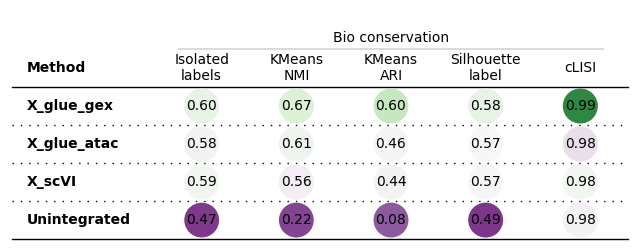

In [13]:
plot_subpart_scib(plot_df, other_cols_bio, column_definitions_bio, "bio_scvi_e15.5.svg")

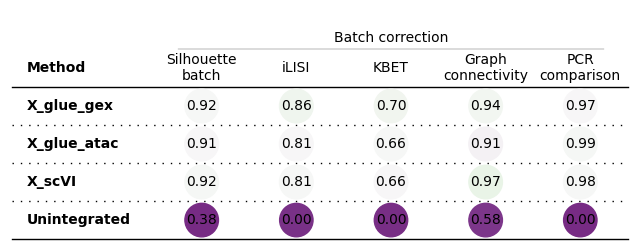

In [14]:
plot_subpart_scib(plot_df, other_cols_batch, column_definitions_batch, "batch_scvi_e15.5.svg")

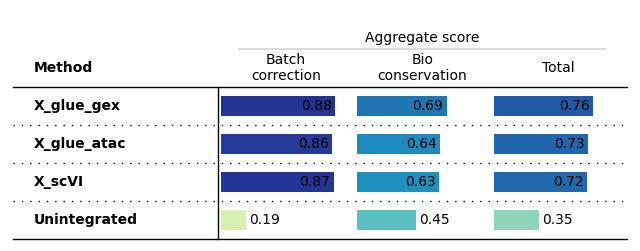

In [15]:
plot_subpart_scib(plot_df, score_cols, column_definitions_agg, "aggregate_e15.5.svg")

/vol/storage/miniconda3/envs/conda_env_robin/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/vol/storage/miniconda3/envs/conda_env_robin/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/vol/storage/miniconda3/envs/conda_env_robin/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/vol/storage/miniconda3/envs/conda_env_robin/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning:

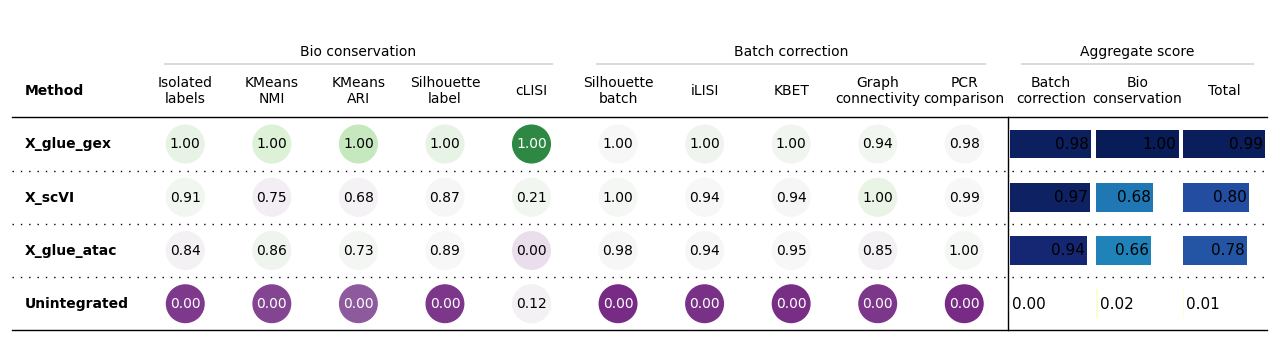

In [16]:
with mplscience.style_context():
    path = FIG_DIR / "benchmark_metrics_min_max_scaled_e15.5"
    path.mkdir(parents=True, exist_ok=True)
    bm.plot_results_table(save_dir=path)

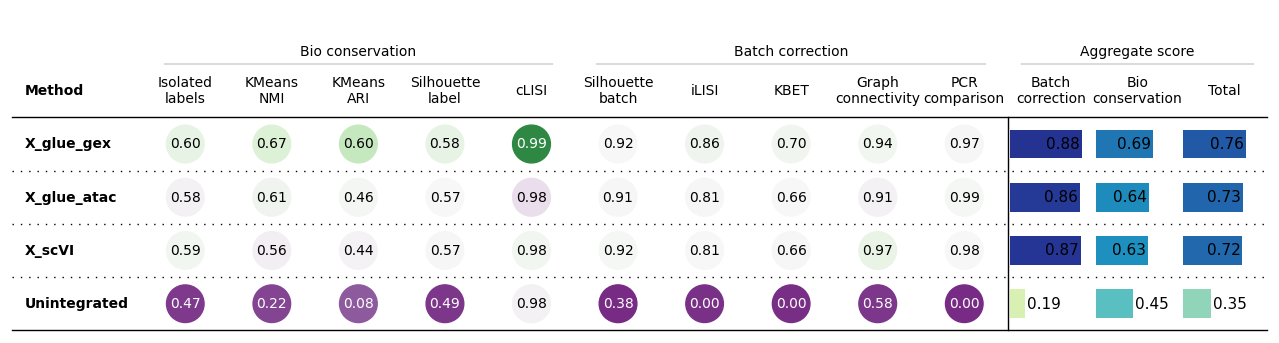

In [17]:
with mplscience.style_context():
    path = FIG_DIR / "benchmark_metrics_e15.5"
    path.mkdir(parents=True, exist_ok=True)
    bm.plot_results_table(min_max_scale=False, save_dir=path)

## Can be run to store colorbar used for pltos

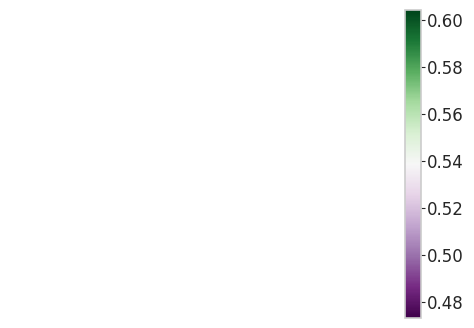

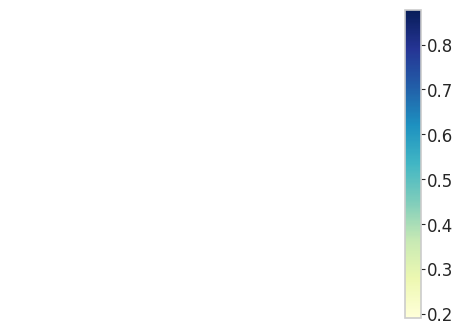

In [18]:
col = other_cols_bio[0]
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(6, 4))
    cmappable = matplotlib.cm.ScalarMappable(
        norm=matplotlib.colors.Normalize(plot_df[col].min(), plot_df[col].max()), cmap=matplotlib.cm.PRGn
    )
    plt.colorbar(cmappable)
    ax.axis("off")
    plt.show()
    if SAVE_FIGURES:
        path = FIG_DIR / "benchmark"
        path.mkdir(parents=True, exist_ok=True)
        fig.savefig(path / "legend_bio.svg", format="svg", dpi=500, transparent=True, bbox_inches="tight")


col = score_cols[0]
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(6, 4))
    cmappable = matplotlib.cm.ScalarMappable(
        norm=matplotlib.colors.Normalize(plot_df[col].min(), plot_df[col].max()), cmap=matplotlib.cm.YlGnBu
    )
    plt.colorbar(cmappable)
    ax.axis("off")
    plt.show()
    if SAVE_FIGURES:
        path = FIG_DIR / "benchmark"
        path.mkdir(parents=True, exist_ok=True)
        fig.savefig(path / "legend_agg.svg", format="svg", dpi=500, transparent=True, bbox_inches="tight")